In [66]:
# -*- coding: utf-8 -*-

"""
Created on Thu Oct 17 18:33:06 2019

@author: steve
"""

'\nCreated on Thu Oct 17 18:33:06 2019\n\n@author: steve\n'

In [67]:
# rbf layer from https://github.com/PetraVidnerova/rbf_keras

from keras import backend as K
# from keras.engine.topology import Layer
from keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np

In [68]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


### read input & output data

In [69]:
import pandas as pd #與Panel、DataFrame 與 Series 相呼應

#read input & output data
x_train=open("../dataset/MackeyGlass/train_X.txt")
x_train=pd.read_csv(x_train, sep="\t",header=0)
y_train=open("../dataset/MackeyGlass/train_y.txt")
y_train=(pd.read_csv(y_train, sep="\t",header=0)).iloc[:,1]

x_test=open("../dataset/MackeyGlass/test_X.txt")
x_test=pd.read_csv(x_test, sep="\t",header=0)
y_test=open("../dataset/MackeyGlass/test_Y.txt")
y_test=(pd.read_csv(y_test, sep="\t",header=0)).iloc[:,1]

### using input label

In [70]:
data_in=x_train
data_real_out=y_train
test_in=x_test
test_real_out=y_test


### data normalization

In [71]:
data_in_max=data_in.max()
data_in_min=data_in.min()
data_in_norm=(data_in-data_in_min)/(data_in_max-data_in_min)
data_in_norm=np.asarray(data_in_norm)

data_real_out_max=data_real_out.max()
data_real_out_min=data_real_out.min()
data_real_out_norm=(data_real_out-data_real_out_min)/(data_real_out_max-data_real_out_min)
data_real_out_norm=np.asarray(data_real_out_norm)

test_in_max=test_in.max()
test_in_min=test_in.min()
test_in_norm=(test_in-test_in_min)/(test_in_max-test_in_min)
test_in_norm=np.asarray(test_in_norm)

test_real_out_max=test_real_out.max()
test_real_out_min=test_real_out.min()
test_real_out_norm=(test_real_out-test_real_out_min)/(test_real_out_max-test_real_out_min)
test_real_out_norm=np.asarray(test_real_out_norm)

### Build Model

In [72]:
#define error function & calculate model's output error
def np_RMSE(output,output_pred):
    rmserror=0
    for i in range(len(output)):
        rmserror=rmserror+np.square(output[i]-output_pred[i])
    rmserror=np.sqrt(rmserror/len(output))
    return rmserror

def np_R2(output,output_pred):
    return np.square(np.corrcoef(output.reshape(np.size(output)),output_pred.reshape(np.size(output_pred)), False)[1,0])

#### 1-b. 以交叉驗證方式訓練BPNN模式，列初步同分組組合之RMSE與$R^2$值

In [73]:
from keras.models import Sequential,load_model
from keras import backend as K
from keras.layers import Dense
from keras.layers.core import Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam_v2
#from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import KFold
from keras.callbacks import History
from keras.metrics import mean_squared_error as mserr

history = History()

RMSE_history_list = []
R2_history_list = []
seed = 7
best_RMSE = np.inf
kfold = KFold(n_splits=3, shuffle=False)
for train, validation in kfold.split(data_in_norm, data_real_out_norm):

    K.clear_session()
    # 模型結構
    model = Sequential()
    model.add(RBFLayer(10,initializer=InitCentersRandom(data_in_norm),betas=1.0,input_shape=(len(data_in_norm[0]),)))
    model.add(Activation('tanh'))
    model.add(Dense(1))

    # 模型相關設定
    learning_rate=1e-4 #設定學習速率
    adam = adam_v2.Adam(lr=learning_rate) #設定的優化器
    model.compile(optimizer=adam,loss="mse") #執行設定好的優化器和誤差函數
    # earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=0) #設定early stopping的參數
    # checkpoint =ModelCheckpoint("rbf-model.hdf5",save_best_only=True)
    #每次迭代儲存模式，我設定了最終只儲存最佳的模式(當驗證誤差最小的時候)
    # callback_list=[earlystopper,checkpoint]
    model.fit(data_in_norm,data_real_out_norm,
              epochs=200, batch_size=8, validation_split=0.2, workers=8
              # callbacks=callback_list
              )

    prediction = np.squeeze(model.predict(data_in_norm[validation]))
    current_RMSE = np_RMSE(prediction, data_real_out_norm[validation])
    current_R2 = np_R2(prediction, data_real_out_norm[validation])
    RMSE_history_list.append(current_RMSE)
    R2_history_list.append(current_R2)

    if (current_RMSE < best_RMSE):
        best_RMSE = current_RMSE
        model.save("rbf-model.hdf5")
        print(f'best model updated!')
    #執行模式訓練并且把設定好的early stopping以及儲存模式參數套用到訓練中

#more details reference: https://keras.io/


Epoch 1/200
 1/50 [..............................] - ETA: 7s - loss: 0.4962

C:\Users\woody\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


50/50 [==============================] - 0s 3ms/step - loss: 0.3925 - val_loss: 0.4630
Epoch 2/200
50/50 [==============================] - 0s 2ms/step - loss: 0.3435 - val_loss: 0.4147
Epoch 3/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2996 - val_loss: 0.3708
Epoch 4/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2607 - val_loss: 0.3316
Epoch 5/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2266 - val_loss: 0.2960
Epoch 6/200
50/50 [==============================] - 0s 2ms/step 

In [74]:
df = pd.DataFrame(list(zip(RMSE_history_list, R2_history_list)),
                  columns=['RMSE', 'R2'])

df


,RMSE,R2
0,0.052599,0.963740
1,0.091319,0.854388
2,0.088134,0.904459


In [75]:
#model forecasting result
model.summary()
model=load_model("rbf-model.hdf5", custom_objects={'RBFLayer': RBFLayer}) #把儲存好的最佳模式讀入

batch_size=8
pred_train=(model.predict(data_in_norm,batch_size=batch_size))*(data_real_out_max-data_real_out_min)+data_real_out_min #針對訓練資料做預測
pred_test=(model.predict(test_in_norm,batch_size=batch_size))*(test_real_out_max-test_real_out_min)+test_real_out_min #針對測試資料做預測

rmse=[];r2=[];
rmse.append(np_RMSE(np.asarray(data_real_out),pred_train))
rmse.append(np_RMSE(np.asarray(test_real_out),pred_test))
r2.append(np_R2(np.asarray(data_real_out),pred_train))
r2.append(np_R2(np.asarray(test_real_out),pred_test))

rmse=np.asarray(rmse).reshape(1,2)
rmse=pd.DataFrame(rmse,columns=['train','test'])
r2=np.asarray(r2).reshape(1,2)
r2=pd.DataFrame(r2,columns=['train','test'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer (RBFLayer)        (None, 10)                60        
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


### Plot

Text(0.5, 1.0, 'test RMSE=0.080668315')

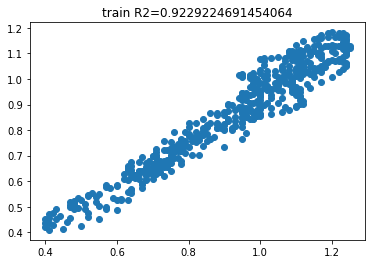

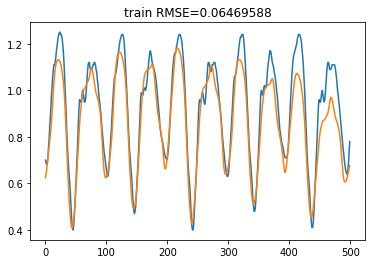

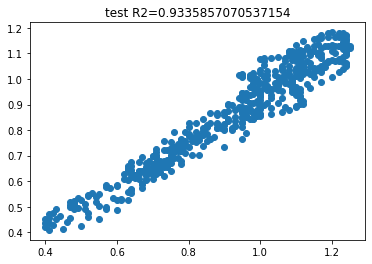

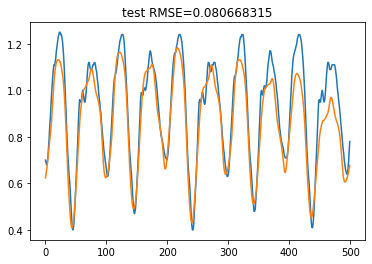

In [76]:
import matplotlib.pyplot as plot

plot1 = plot.figure(1)
plot.scatter(test_real_out,pred_test)
plot.title("train R2=%s"%r2.iloc[0,0])
plot1 = plot.figure(2)
plot.plot(test_real_out)
plot.plot(pred_test)
plot.title("train RMSE=%s"%rmse.iloc[0,0])
plot1 = plot.figure(3)
plot.scatter(test_real_out,pred_test)
plot.title("test R2=%s"%r2.iloc[0,1])
plot1 = plot.figure(4)
plot.plot(test_real_out)
plot.plot(pred_test)
plot.title("test RMSE=%s"%rmse.iloc[0,1])